# Koszty ubezpieczenia medycznego

## Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.pylab import rcParams

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Analiza bazy

### Wczytanie danych

In [2]:
insurance_df = pd.read_csv('insurance.csv')

### Wyświetlenie danych

In [3]:
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Sprawdzenie typów danych i wartości nullowych

In [4]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Baza nie zawiera wartości nullowych.

### Przekształcenie wartości kategorycznych

In [5]:
le = LabelEncoder()
insurance_df['sex'] = le.fit_transform(insurance_df['sex'])
insurance_df['smoker'] = le.fit_transform(insurance_df['smoker'])
insurance_df['region'] = le.fit_transform(insurance_df['region'])

### Sprawdzenie statystyk

In [6]:
insurance_df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


### Analiza korelacji

In [7]:
correlation = insurance_df.corr()
correlation['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

Wyświetlenie korelacji w formie graficznej

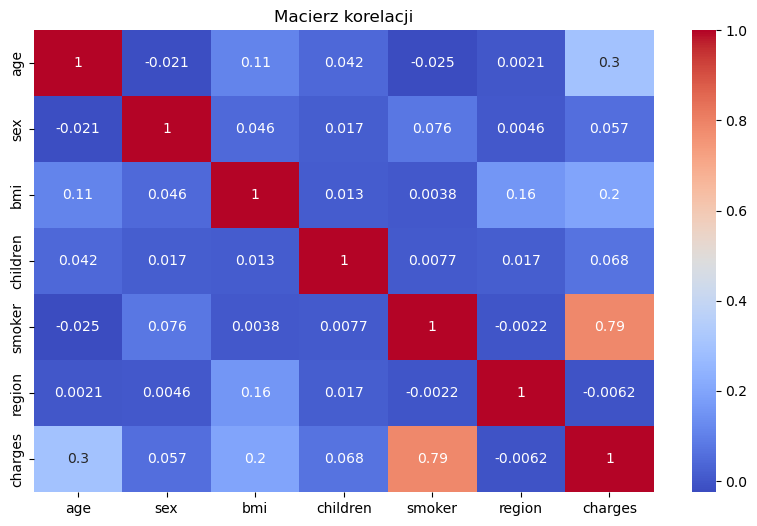

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Macierz korelacji")
plt.show()

### Analiza wieku

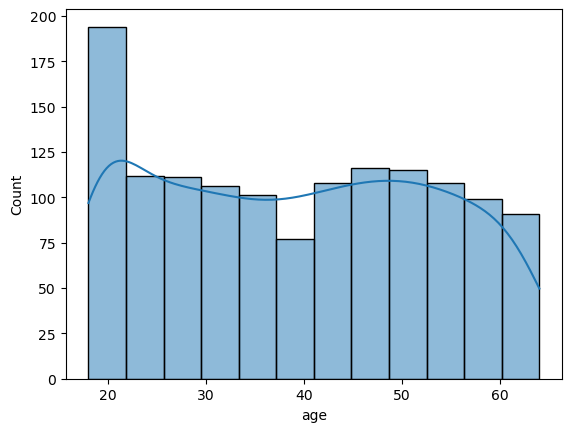

In [9]:
sns.histplot(insurance_df['age'], kde=True)
plt.show()

Grupa badawcza to populacja w wieku produkcyjnym (18 - 64 lata)

### Analiza zależności między płcią, regionem, paleniem, BMI, posiadaniem dzieci a kosztami ubezpieczenia

In [10]:
# Utworzenie kopii df
analysis_df = insurance_df.copy()

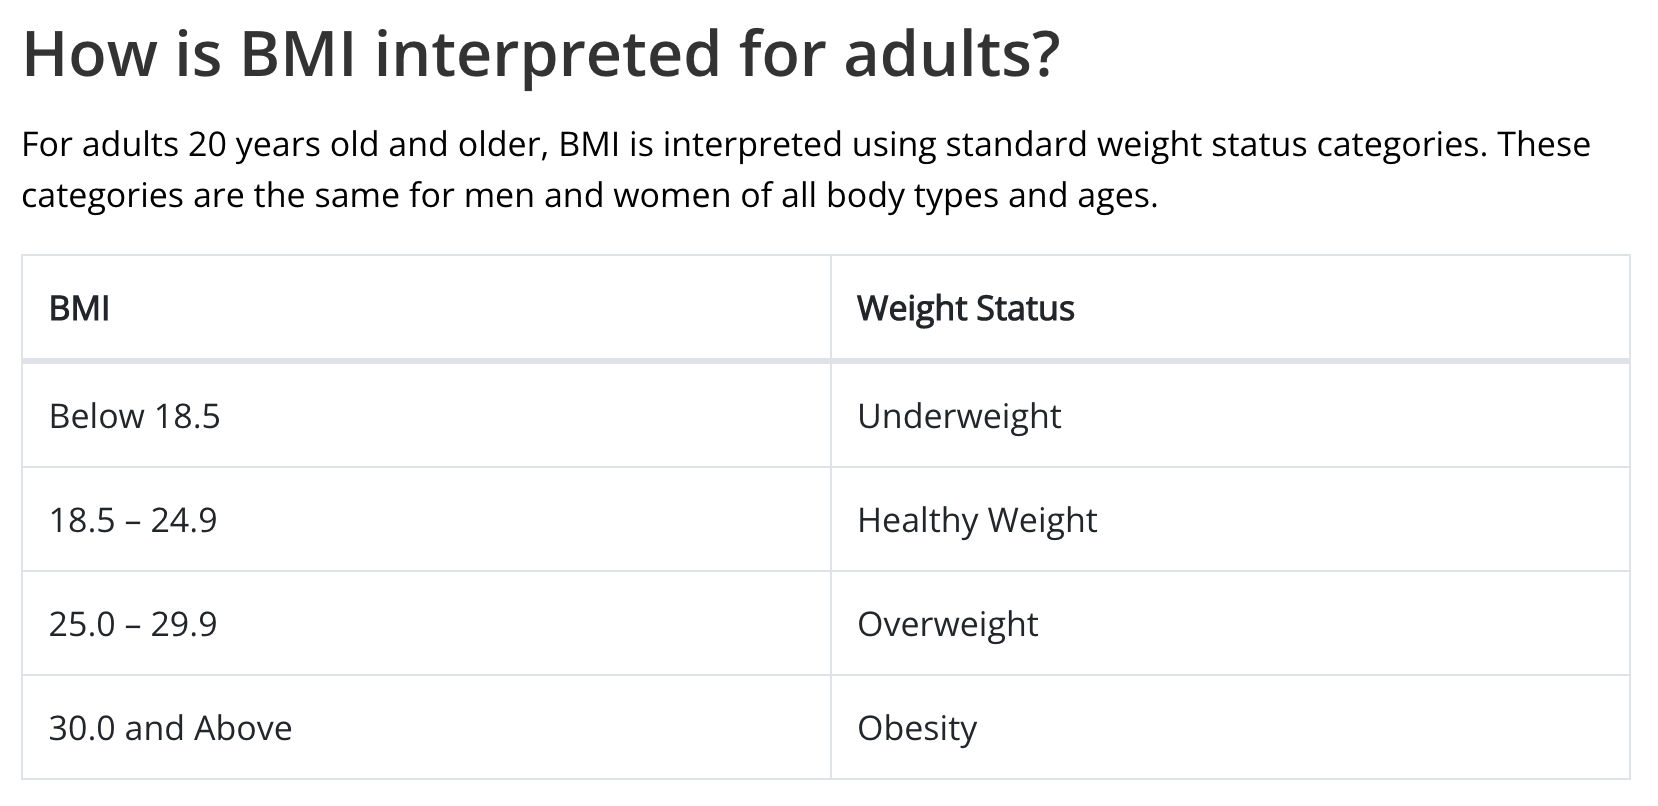

Baza zwiera populację w wieku produkcyjnym, dlatego powyzszy podział został przyjęty dla wszystkich badanych

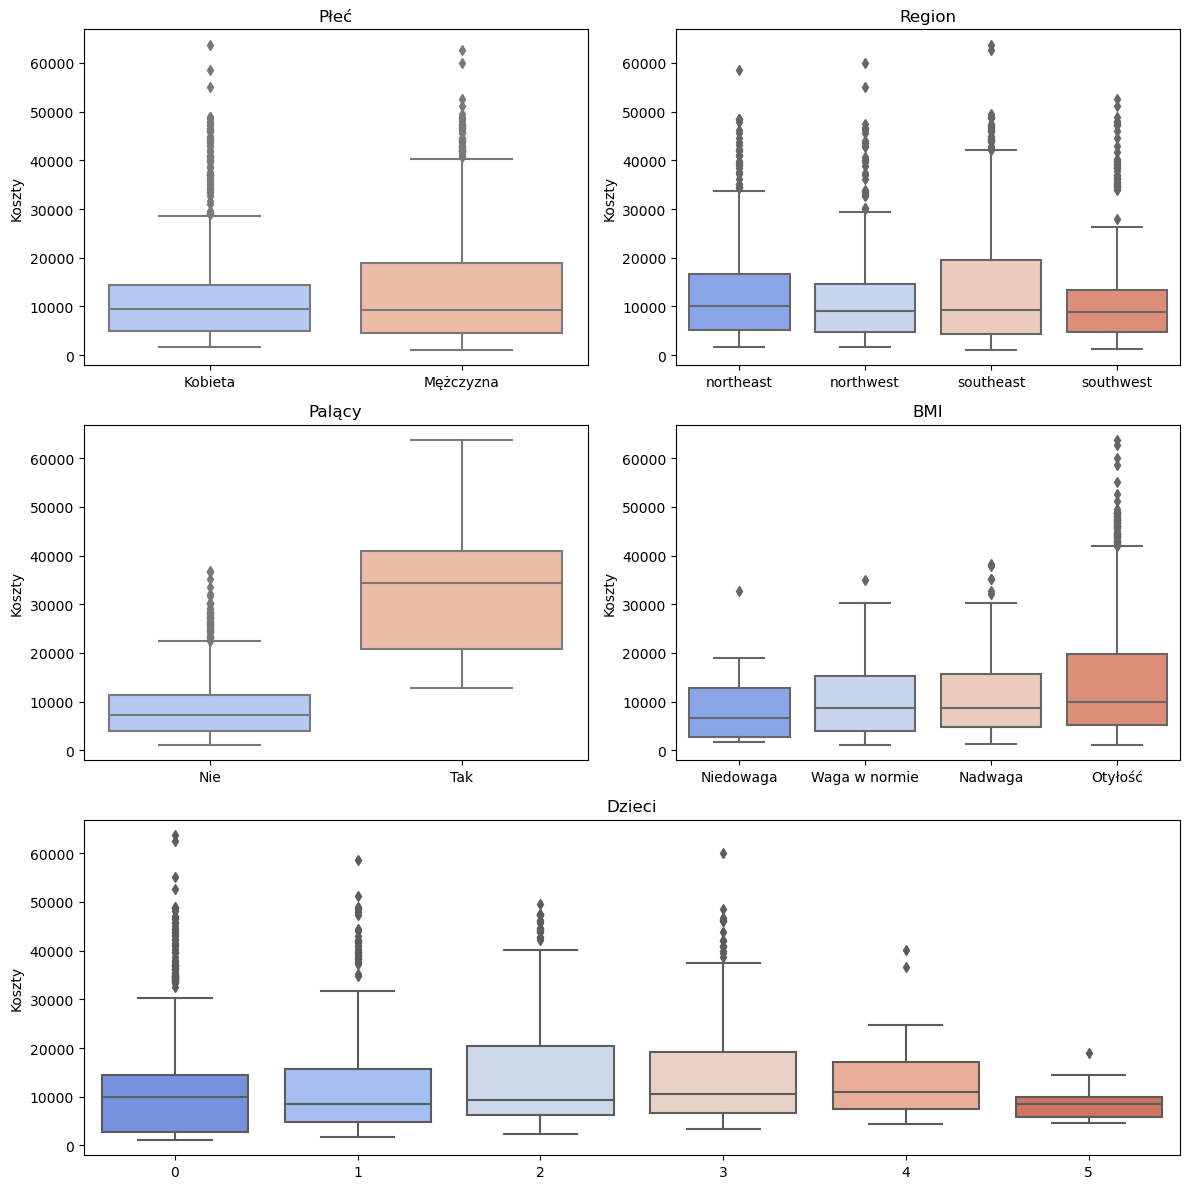

In [11]:
analysis_df['bmi_category'] = pd.cut(analysis_df['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], labels=['Niedowaga', 'Waga w normie', 'Nadwaga', 'Otyłość'])

plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
sns.boxplot(x='sex', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Płeć")
plt.xlabel("")
plt.ylabel("Koszty")
plt.xticks([0, 1], ['Kobieta', 'Mężczyzna'])

plt.subplot(3, 2, 2)
sns.boxplot(x='region', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Region")
plt.xlabel("")
plt.ylabel("Koszty")
plt.xticks([0, 1, 2, 3], ['northeast', 'northwest', 'southeast', 'southwest'])

plt.subplot(3, 2, 3)
sns.boxplot(x='smoker', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Palący")
plt.xlabel("")
plt.ylabel("Koszty")
plt.xticks([0, 1], ['Nie', 'Tak'])

plt.subplot(3, 2, 4)
sns.boxplot(x='bmi_category', y='charges', data=analysis_df, palette='coolwarm')
plt.title("BMI")
plt.xlabel("")
plt.ylabel("Koszty")

plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.boxplot(x='children', y='charges', data=analysis_df, palette='coolwarm')
plt.title("Dzieci")
plt.xlabel("")
plt.ylabel("Koszty")

plt.tight_layout()
plt.show()

### Pairplot z podziałem na palących i niepalących

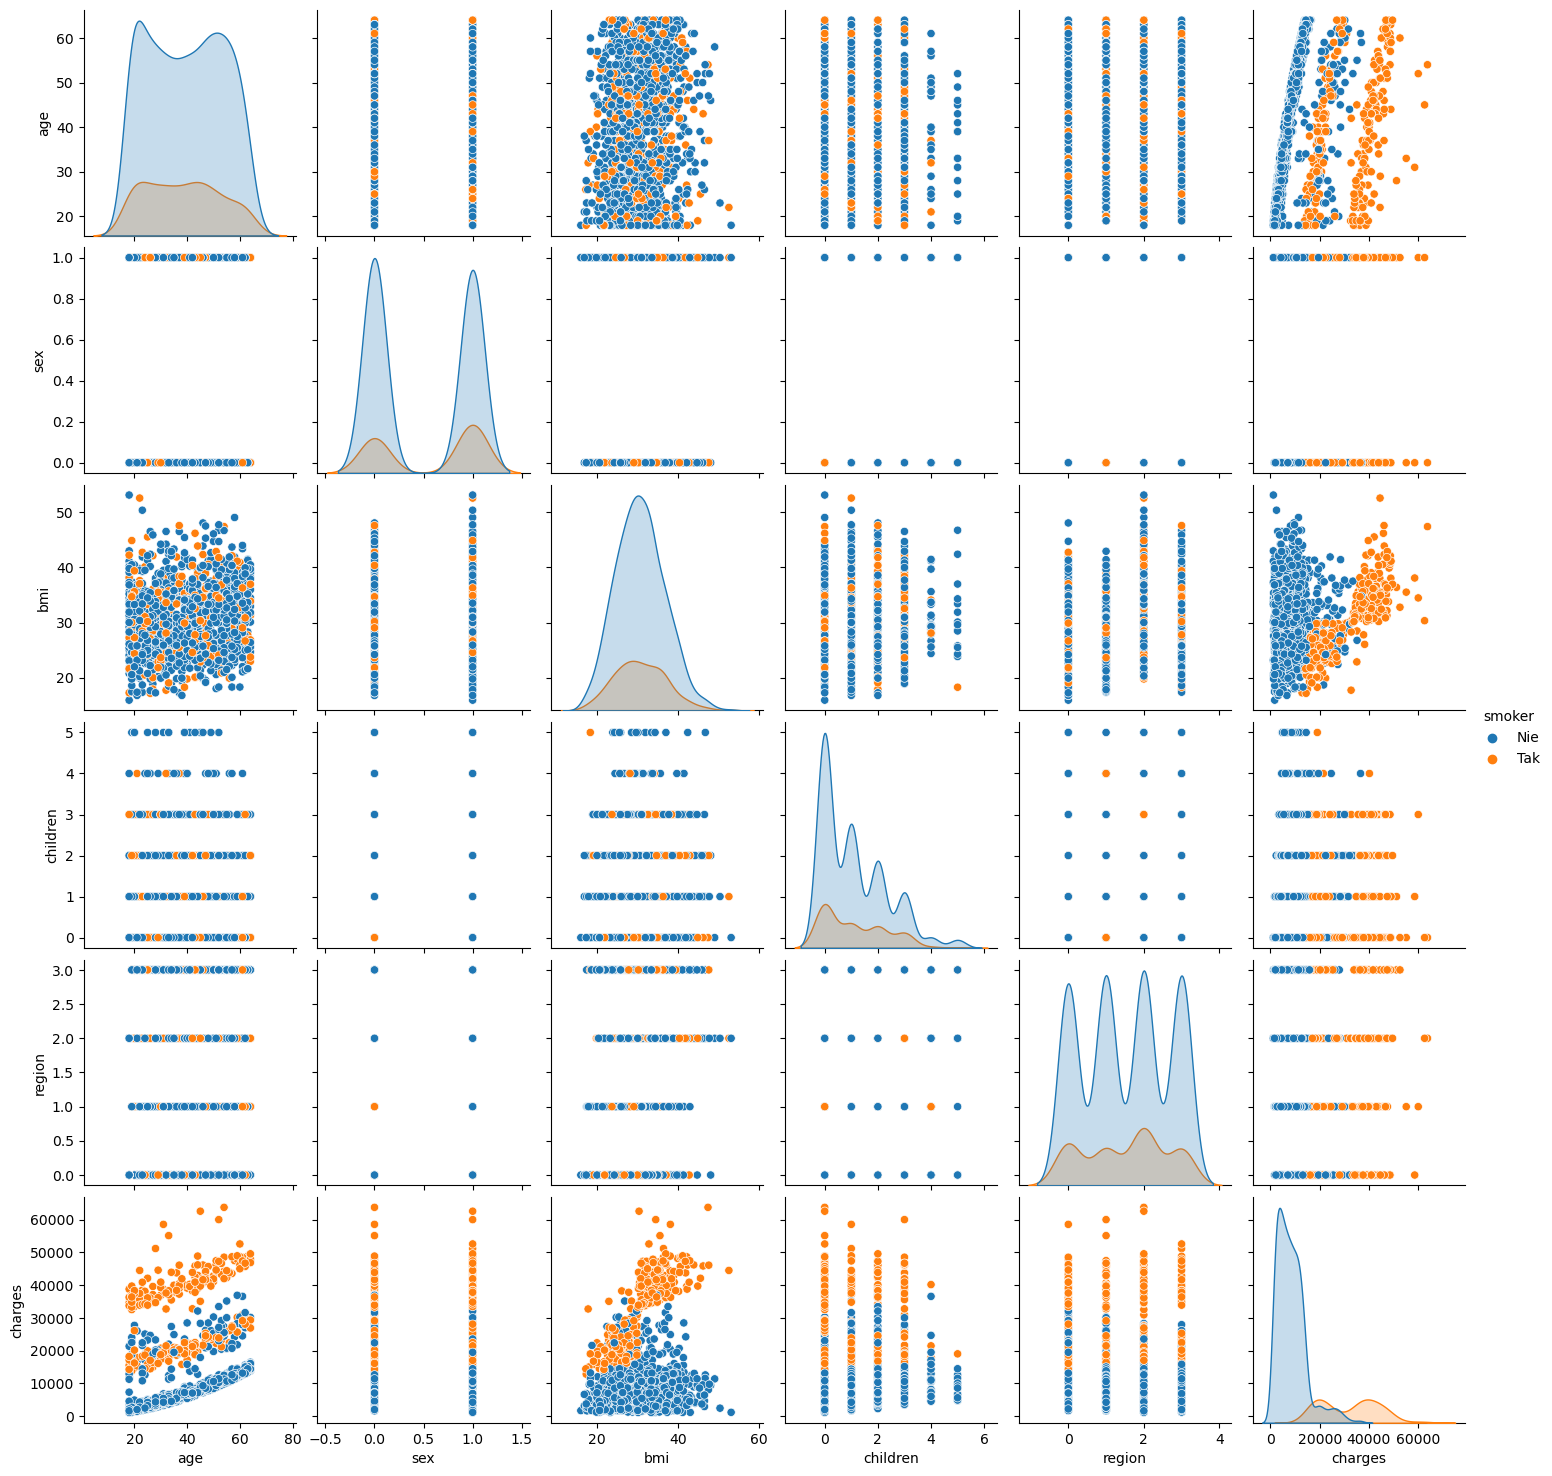

In [12]:
pplot = sns.pairplot(analysis_df, hue="smoker")
legend_labels = ['Nie', 'Tak']
for t, l in zip(pplot._legend.texts, legend_labels):
    t.set_text(l)
plt.show()

### Porównanie korelacji z podziałem na palących i niepalących

In [13]:
insurance_df_s = analysis_df[(analysis_df['smoker'] == 1)]
insurance_df_ns = analysis_df[(analysis_df['smoker'] == 0)]

corr_matrix_s = insurance_df_s.drop(columns=['smoker', 'bmi_category']).corr().sort_values('charges', ascending=False)
corr_matrix_ns = insurance_df_ns.drop(columns=['smoker', 'bmi_category']).corr().sort_values('charges', ascending=False)

Korelacje dla palących

In [14]:
corr_matrix_s['charges'].sort_values(ascending=False)

charges     1.000000
bmi         0.806481
age         0.368224
region      0.128983
sex         0.101226
children    0.035945
Name: charges, dtype: float64

Korelacje dla niepalących

In [15]:
corr_matrix_ns['charges'].sort_values(ascending=False)

charges     1.000000
age         0.627947
children    0.138929
bmi         0.084037
sex        -0.056320
region     -0.073316
Name: charges, dtype: float64

Porównanie graficzne

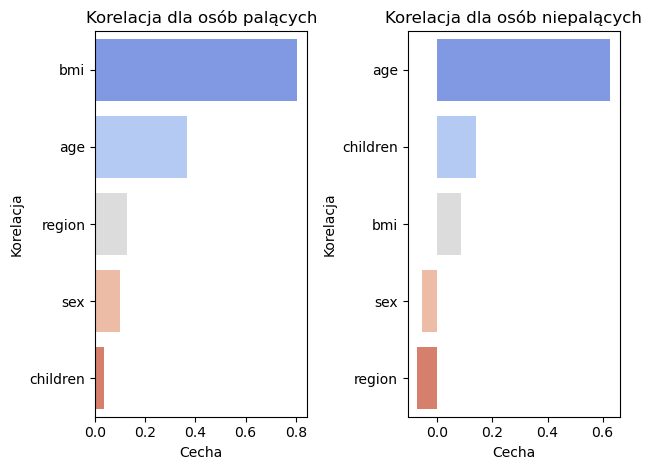

In [16]:
plt.subplot(1, 2, 1)
sns.barplot(x=corr_matrix_s['charges'].drop('charges').values, y=corr_matrix_s['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób palących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.subplot(1, 2, 2)
sns.barplot(x=corr_matrix_ns['charges'].drop('charges').values, y=corr_matrix_ns['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób niepalących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.tight_layout()
plt.show()

Wśród osób niepalących mozemy zaobserwowac ujemną korelację, dlatego na potrzeby wizualizacji i oszacowania istotności cech przekształacmy wartości na dodatnie.

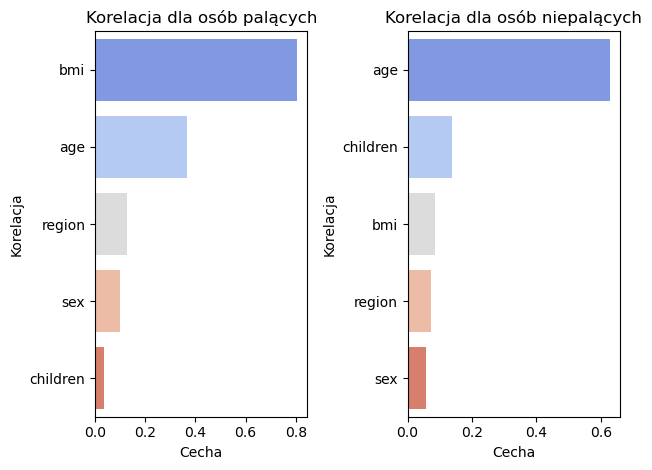

In [17]:
corr_matrix_ns_abs = abs(corr_matrix_ns).sort_values('charges', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(x=corr_matrix_s['charges'].drop('charges').values, y=corr_matrix_s['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób palących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.subplot(1, 2, 2)
sns.barplot(x=corr_matrix_ns_abs['charges'].drop('charges').values, y=corr_matrix_ns_abs['charges'].drop('charges').index, palette='coolwarm')
plt.title('Korelacja dla osób niepalących')
plt.xlabel('Cecha')
plt.ylabel('Korelacja')

plt.tight_layout()
plt.show()

## ML - Modele predyckcji ceny ubezpieczenia

### Przygotowanie zbiru testowego i treningowego

Podział na zbiór cech (X) i zmienną zależną (y)

In [18]:
X = insurance_df.drop(columns=['charges'], axis=1)
y = insurance_df['charges']

Podział na zbiór treningowy i testowy

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Przygotowanie transformacji dla zmiennych

In [20]:
numeric_features = ['age', 'bmi', 'sex', 'smoker', 'region', 'children']
numeric_transformer = PolynomialFeatures(degree=2)

Połączenie transformacji dla wszystkich zmiennych

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

### Model regresji liniowej

In [22]:
lr = LinearRegression()

# Pipeline
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', lr)])

# Trenowanie modelu
model_lr.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model_lr.predict(X_test)

# Wyniki dla modelu regresji liniowej
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

# Wyświetlenie wyniku
print(f'MSE = {mse_lr}\nR2 = {r2_lr}')

MSE = 20620933.77354363
R2 = 0.8671748646484991


### Model regresji Lasso

In [23]:
lasso = Lasso(alpha=0.1, random_state=42)

# Pipeline dla regresji Lasso
model_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', lasso)])

# Trenowanie modelu Lasso
model_lasso.fit(X_train, y_train)

# Predykcja na zbiorze testowym dla Lasso
y_pred_lasso = model_lasso.predict(X_test)

# Wyniki dla modelu regresji Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Wyświetlenie wyniku
print(f'MSE = {mse_lasso}\nR2 = {r2_lasso}')

MSE = 20531024.342153307
R2 = 0.8677539961526757


/opt/anaconda3/envs/envpy310/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+10, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


### Model regresji Ridge

In [24]:
ridge = Ridge(alpha=1.0, random_state=42)

# Pipeline dla regresji Ridge
model_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', ridge)])

# Trenowanie modelu Ridge
model_ridge.fit(X_train, y_train)

# Predykcja na zbiorze testowym dla Ridge
y_pred_ridge = model_ridge.predict(X_test)

# Wyniki dla modelu regresji Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Wyświetlenie wyniku
print(f'MSE = {mse_ridge}\nR2 = {r2_ridge}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MSE = 20473506.961388003
R2 = 0.8681244815035871


### Model regresji ElasticNet

In [25]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

# Pipeline dla regresji ElasticNet
model_enet = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', enet)])

# Trenowanie modelu ElasticNet
model_enet.fit(X_train, y_train)

# Predykcja na zbiorze testowym dla ElasticNet
y_pred_enet = model_enet.predict(X_test)

# Wyniki dla modelu regresji ElasticNet
mse_enet = mean_squared_error(y_test, y_pred_enet)
r2_enet = r2_score(y_test, y_pred_enet)

# Wyświetlenie wyniku
print(f'MSE = {mse_enet}\nR2 = {r2_enet}')

MSE = 21462960.51617626
R2 = 0.8617511376103348


### Model regresji DecisionTreeRegressor

In [26]:
tree = DecisionTreeRegressor(random_state=42)

# Pipeline dla regresji DecisionTreeRegressor
model_tree = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', tree)])

# Trenowanie modelu DecisionTreeRegressor
model_tree.fit(X_train, y_train)

# Predykcja na zbiorze testowym dla DecisionTreeRegressor
y_pred_tree = model_tree.predict(X_test)

# Wyniki dla modelu regresji DecisionTreeRegressor
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Wyświetlenie wyniku
print(f'MSE = {mse_tree}\nR2 = {r2_tree}')

MSE = 31438182.99442346
R2 = 0.7974979718524183


### Model XGBoost

In [27]:
xg_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', max_depth=4, learning_rate=0.05)

# Pipeline dla regresji XGBoost
model_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', xg_reg)])

# Trenowanie modelu XGBoost
model_xgb.fit(X_train, y_train)

# Predykcja na zbiorze testowym dla XGBoost
y_pred_xgb = model_xgb.predict(X_test)

# Wyniki dla modelu regresji XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Wyświetlenie wyniku
print(f'MSE = {mse_xgb}\nR2 = {r2_xgb}')

MSE = 18345230.86310101
R2 = 0.8818332962413087


In [60]:
numeric_features = ['age', 'bmi', 'sex', 'smoker', 'region', 'children']
numeric_transformer = PolynomialFeatures(degree=2)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Dopasowanie transformacji i transformacja danych treningowych
X_train_transformed = preprocessor.fit_transform(X_train)

# Pobranie nazw cech po transformacji
feature_names = preprocessor.named_transformers_['num'].get_feature_names_out(input_features=numeric_features)

# Konwersja danych przekształconych na DataFrame z nazwami cech
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Inicjalizacja regresora XGBoost
xg_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', max_depth=4, learning_rate=0.05)

# Trenowanie modelu XGBoost na danych przekształconych
model_xgb = xg_reg.fit(X_train_transformed_df, y_train)

# Transformacja danych testowych
X_test_transformed = preprocessor.transform(X_test)

# Predykcja na zbiorze testowym dla XGBoost
y_pred_xgb = model_xgb.predict(X_test_transformed)

# Wyniki dla modelu regresji XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Wyświetlenie wyników
print(f'MSE = {mse_xgb}\nR2 = {r2_xgb}')

MSE = 18345230.86310101
R2 = 0.8818332962413087


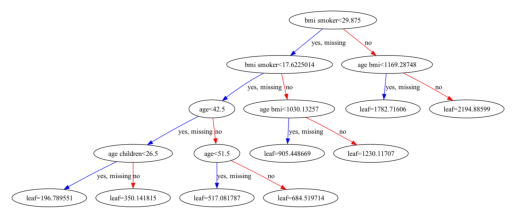

In [29]:
xgb.plot_tree(model_xgb, num_trees=0)
plt.show()

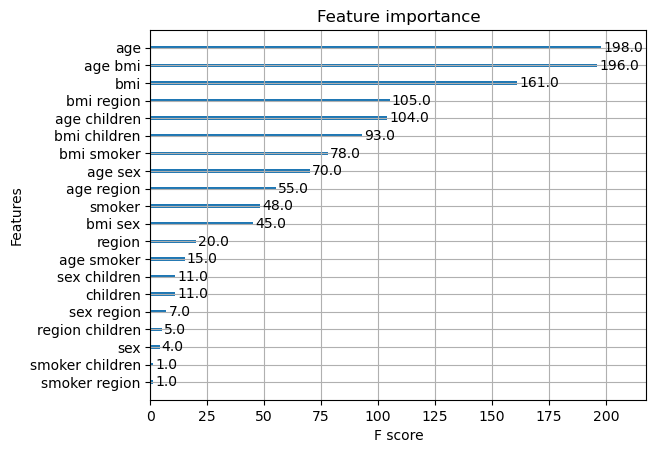

In [30]:
xgb.plot_importance(model_xgb)
plt.show()

### Zestawienie wyników

In [31]:
results = pd.DataFrame({'Model': ['Regresja Liniowa', 'Lasso', 'Ridge', 'ElasticNet', 'DecisionTreeRegressor', 'XGBoost'],
                        'MSE': [mse_lr, mse_lasso, mse_ridge, mse_enet, mse_tree, mse_xgb],
                        'R2 Score': [r2_lr, r2_lasso, r2_ridge, r2_enet, r2_tree, r2_xgb]})

# Zmiana wyświetlania notacji naukowe na float
pd.options.display.float_format = '{:.2f}'.format

results

,Model,MSE,R2 Score
0,Regresja Liniowa,20620933.77,0.87
1,Lasso,20531024.34,0.87
2,Ridge,20473506.96,0.87
3,ElasticNet,21462960.52,0.86
4,DecisionTreeRegressor,31438182.99,0.80
5,XGBoost,18345230.86,0.88


In [32]:
results.sort_values('MSE')

,Model,MSE,R2 Score
5,XGBoost,18345230.86,0.88
2,Ridge,20473506.96,0.87
1,Lasso,20531024.34,0.87
0,Regresja Liniowa,20620933.77,0.87
3,ElasticNet,21462960.52,0.86
4,DecisionTreeRegressor,31438182.99,0.80


In [33]:
results.sort_values('R2 Score', ascending=False)

,Model,MSE,R2 Score
5,XGBoost,18345230.86,0.88
2,Ridge,20473506.96,0.87
1,Lasso,20531024.34,0.87
0,Regresja Liniowa,20620933.77,0.87
3,ElasticNet,21462960.52,0.86
4,DecisionTreeRegressor,31438182.99,0.80


Wykresy porównujący wyniki

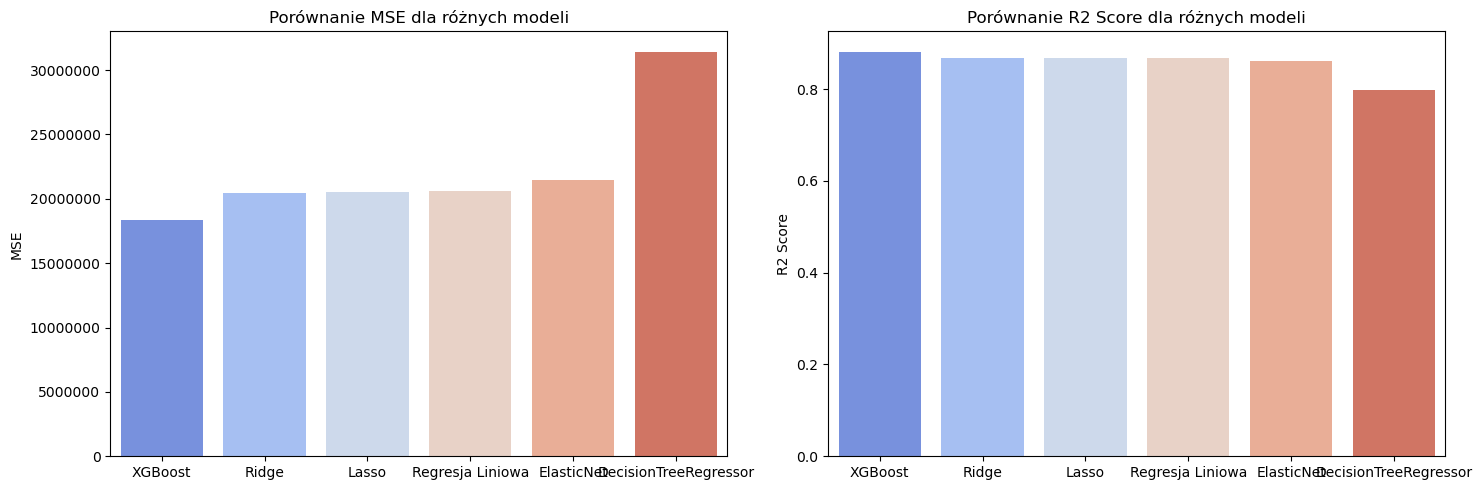

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=results.sort_values('MSE'), palette='coolwarm')
plt.title('Porównanie MSE dla różnych modeli')
plt.xlabel('')
plt.ylabel('MSE')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2 Score', data=results.sort_values('R2 Score', ascending=False), palette='coolwarm')
plt.title('Porównanie R2 Score dla różnych modeli')
plt.xlabel('')
plt.ylabel('R2 Score')

plt.tight_layout()
plt.show()

Wnioski:

- Najlepiej zastosowac model XGBoost
- Biorąc pod uwagę róznice korelacji dla palących i nie palących, dobrze by było posiadac więcej (inne?) zmiennych dla tych grup

Komentarz:

Rzeczy nieujęte w powyzszym kodzie

- Wykonanie dwóch modeli - dla palących i dla niepalących daje bardzo słabe rezultaty (wynik ponizej 0.5 dla jdenej z grup)
- Wynik nieznacznie się poprawia przy pominięciu 'region'. Przy usunięciu kolejnych zmiennych pogarsza się
- Lepsze wyniki osiągamy przy LabelEncoder i wielomianie (PolynomialFeatures), niz przy OneHotEncoder. Nawet dla zmiennych kategorycznych

## XGBoost

In [35]:
xg_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', max_depth=3, learning_rate=0.05)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
xg_reg.score(X_test, y_test)

0.8802647340017784

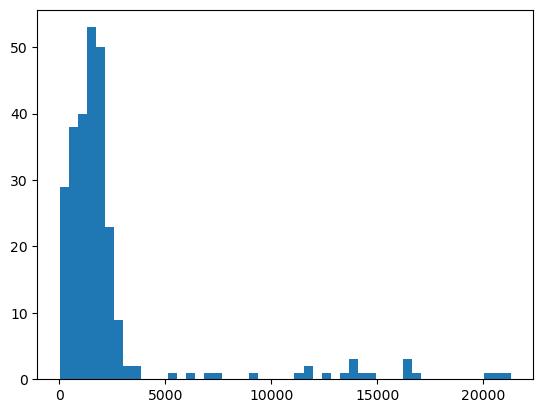

In [36]:
plt.hist(np.abs(y_test - y_pred), bins=50)
plt.show()

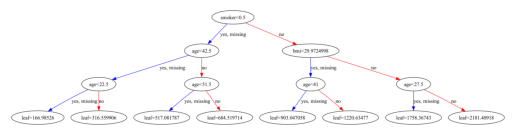

In [37]:
#rcParams['figure.figsize'] = 10, 8

xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

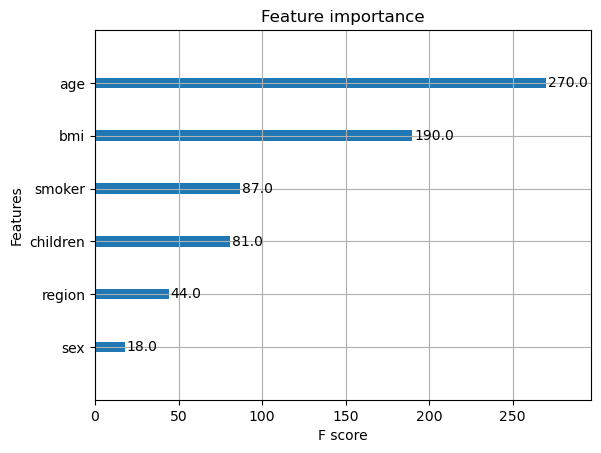

In [38]:
xgb.plot_importance(xg_reg)
plt.show()

In [39]:
insurance_df['charges'].head()

0   16884.92
1    1725.55
2    4449.46
3   21984.47
4    3866.86
Name: charges, dtype: float64

In [40]:
np.log10(insurance_df['charges'].head())

0   4.23
1   3.24
2   3.65
3   4.34
4   3.59
Name: charges, dtype: float64

In [41]:
min(np.log10(insurance_df['charges'].head())), max(np.log10(insurance_df['charges'].head()))

(3.236928126917674, 4.342116012192527)

In [42]:
10 ** np.log10(insurance_df['charges'].head())

0   16884.92
1    1725.55
2    4449.46
3   21984.47
4    3866.86
Name: charges, dtype: float64

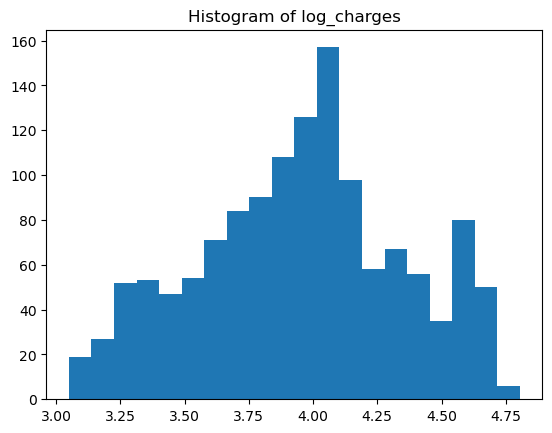

In [43]:
plt.hist(np.log10(insurance_df['charges']), bins=20)
_ = plt.title("Histogram of log_charges")

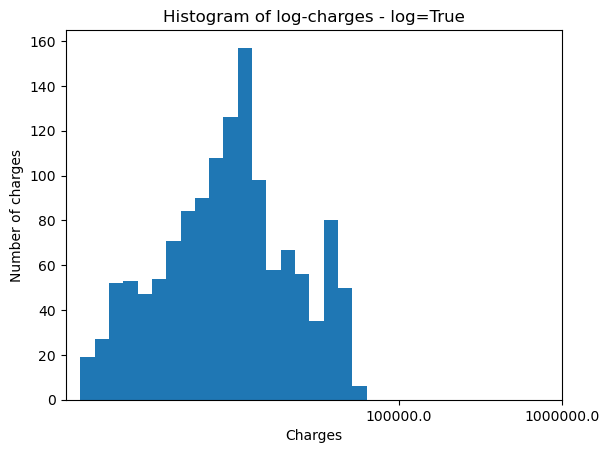

In [44]:
plt.hist(np.log10(insurance_df['charges']), bins=20)
_ = plt.title("Histogram of log-charges - log=True")
plt.xlabel("Charges")
plt.ylabel("Number of charges")
_ = plt.xticks(np.arange(5, 7), np.floor(10 ** (np.arange(5, 7))))

In [45]:
data_dm = xgb.DMatrix(data=X.values, label=y.values)

In [46]:
params = {"objective":"reg:squarederror", "max_depth":4, "learning_rate": 0.1}

In [47]:
lr_vals = [0.001, 0.01, 0.1]

In [48]:
params["learning_rate"] = 0.8
cv_results = xgb.cv(dtrain=data_dm, params=params, nfold=3, num_boost_round=50, 
                            metrics="rmse", as_pandas=True, seed=123)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,5843.16,63.32,5992.04,214.13
1,4330.30,93.94,4654.88,173.26
2,4117.21,105.26,4585.35,193.40
3,3999.49,106.12,4623.68,177.82
4,3875.00,93.49,4696.93,159.50
5,3786.60,114.94,4775.91,229.11
6,3716.44,106.73,4791.39,241.16
7,3621.62,104.38,4831.42,253.80
8,3496.50,103.15,4870.00,259.49
9,3374.06,88.20,4949.08,298.59


Text(0, 0.5, 'Bład estymacji')

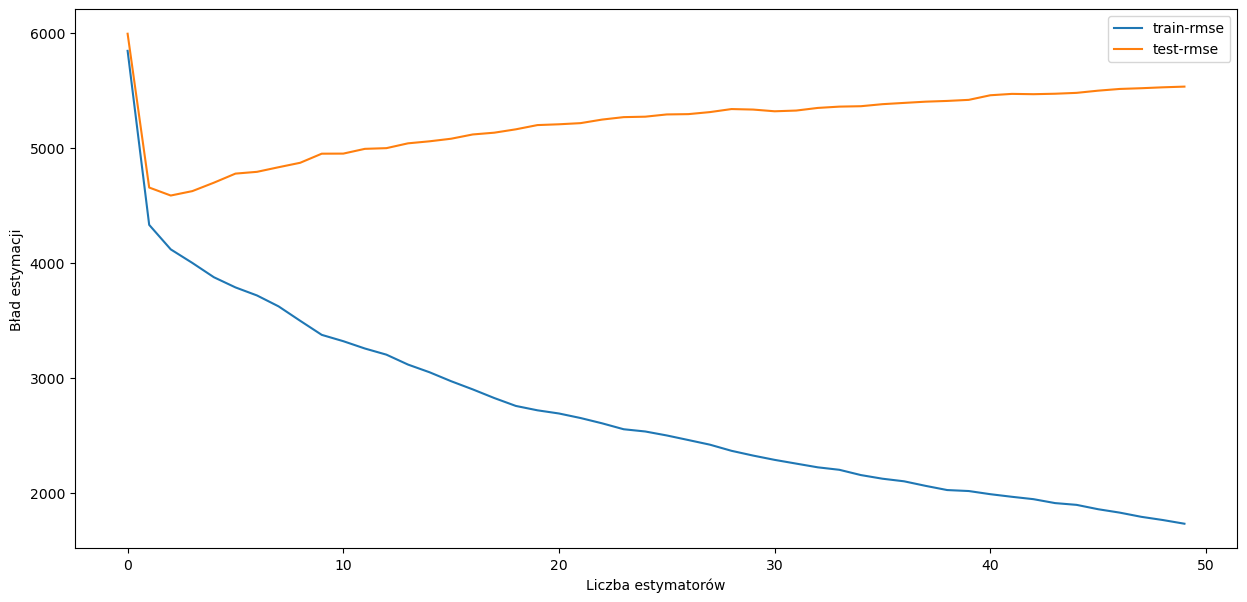

In [49]:
plt.figure(figsize=(15, 7))
plt.plot(cv_results['train-rmse-mean'])
plt.plot(cv_results['test-rmse-mean'])
plt.legend(["train-rmse", "test-rmse"])
plt.xlabel("Liczba estymatorów")
plt.ylabel("Bład estymacji")

In [50]:
lr_array = [0.3, 0.1, 0.05, 0.01, 0.003, 0.001]

{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.3}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.1}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.05}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.01}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.003}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.001}


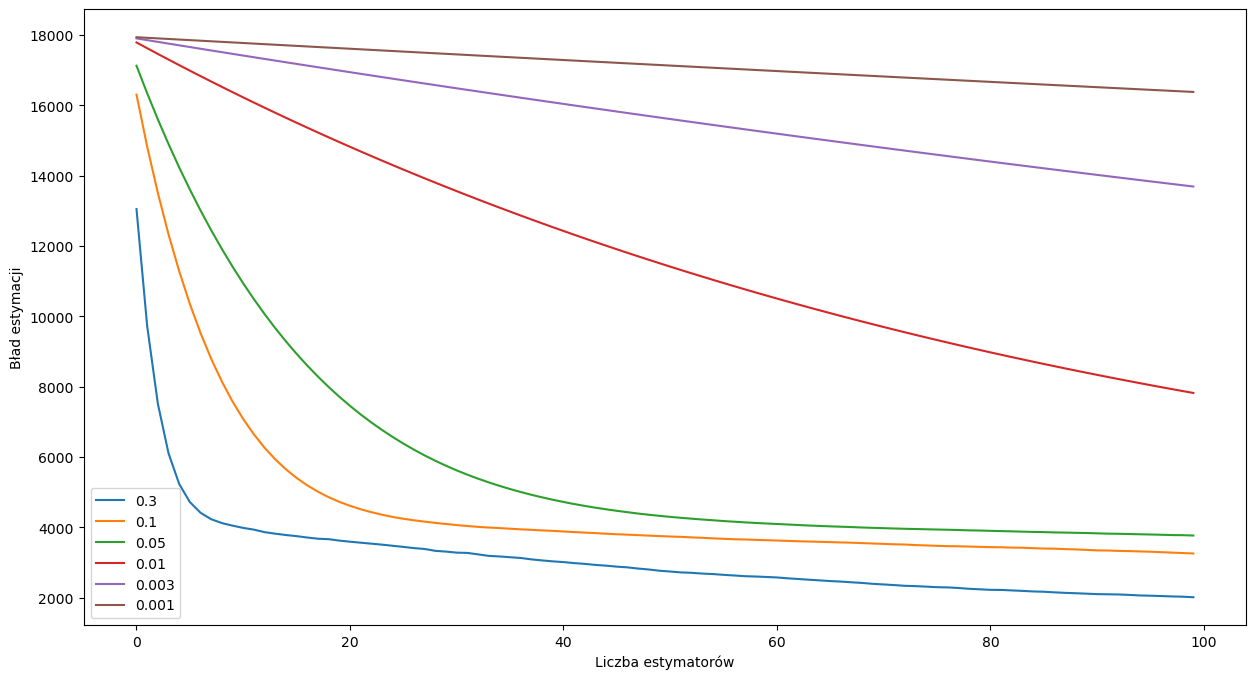

In [51]:
plt.figure(figsize=(15, 8))

for lr in lr_array:
    params["learning_rate"] = lr
    print(params)
    cv_results = xgb.cv(
        dtrain=data_dm, 
        params=params, 
        num_boost_round=100, 
        metrics="rmse", 
        as_pandas=True, 
        seed=123
    )
    plt.plot(cv_results['train-rmse-mean'])

plt.xlabel("Liczba estymatorów")
plt.ylabel("Bład estymacji")
plt.legend(lr_array)
plt.show()

In [52]:
lr_array = [0.05, 0.5, 0.3, 0.1, 0.03, 0.01]

{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.05}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.5}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.3}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.1}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.03}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.01}


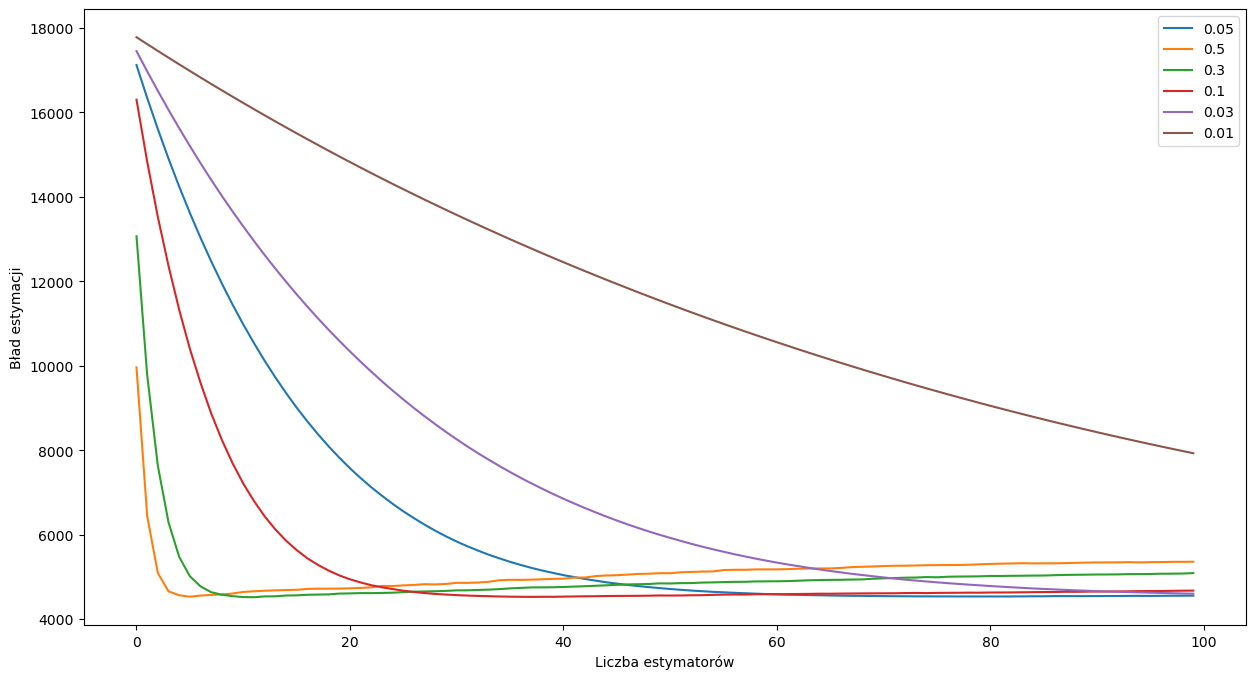

In [53]:
plt.figure(figsize=(15, 8))

for lr in lr_array:
    params["learning_rate"] = lr
    print(params)
    cv_results = xgb.cv(
        dtrain=data_dm, 
        params=params, 
        num_boost_round=100, 
        metrics="rmse", 
        as_pandas=True, 
        seed=123
    )
    plt.plot(cv_results['test-rmse-mean'])

plt.xlabel("Liczba estymatorów")
plt.ylabel("Bład estymacji")
plt.legend(lr_array)
plt.show()

{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.8}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.5}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.3}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.1}
{'objective': 'reg:squarederror', 'max_depth': 4, 'learning_rate': 0.05}


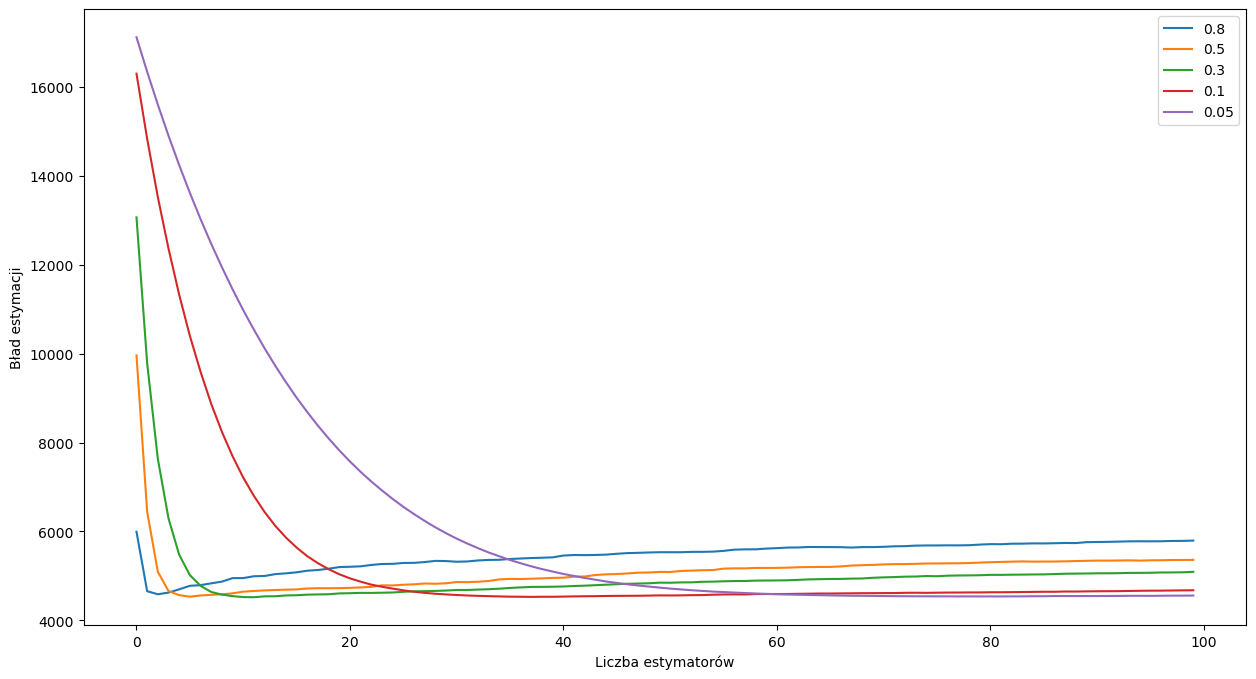

In [54]:
lr_array = [0.8, 0.5, 0.3, 0.1, 0.05]

plt.figure(figsize=(15, 8))

for lr in lr_array:
    params["learning_rate"] = lr
    print(params)
    cv_results = xgb.cv(
        dtrain=data_dm, 
        params=params, 
        num_boost_round=100, 
        metrics="rmse", 
        as_pandas=True, 
        seed=123
    )
    plt.plot(cv_results['test-rmse-mean'])

plt.xlabel("Liczba estymatorów")
plt.ylabel("Bład estymacji")
plt.legend(lr_array)
plt.show()

In [55]:
y_transformed = np.log10(y)
y_transformed

0      4.23
1      3.24
2      3.65
3      4.34
4      3.59
       ... 
1333   4.03
1334   3.34
1335   3.21
1336   3.30
1337   4.46
Name: charges, Length: 1338, dtype: float64

In [56]:
train_X, test_X, train_y, test_y, train_yt, test_yt = train_test_split(
    X, y, y_transformed, test_size=0.2, random_state=42
)
test_y.shape, test_yt.shape

((268,), (268,))

In [57]:
results = {}

for variant in ["transformed", "not_transformed"]:
    for booster in ["gbtree", "gblinear"]:
    
        if variant == "transformed":
            this_train_y = train_yt
        else:
            this_train_y = train_y

        model = xgb.XGBRegressor(booster=booster, n_estimators=100)
        model.fit(train_X, this_train_y)
        pred = model.predict(test_X)
        
        if variant == "transformed":
            pred = 10 ** pred
            
        #score = mean_absolute_error(test_y, pred)
        score = np.sqrt(mean_squared_error(test_y, pred))
        results[(variant, booster)] = score

results

{('transformed', 'gbtree'): 5197.048549194546,
 ('transformed', 'gblinear'): 7799.760101240463,
 ('not_transformed', 'gbtree'): 4736.27039640462,
 ('not_transformed', 'gblinear'): 5846.790812139618}

RMSE - gbtree:  4520.550836209137
MAE - gbtree:  2466.720154055198